# Distilroberta-finetuned-financial-news-sentiment-analysis

In [1]:
#!pip install ktrain
#!pip install sentence_transformers

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


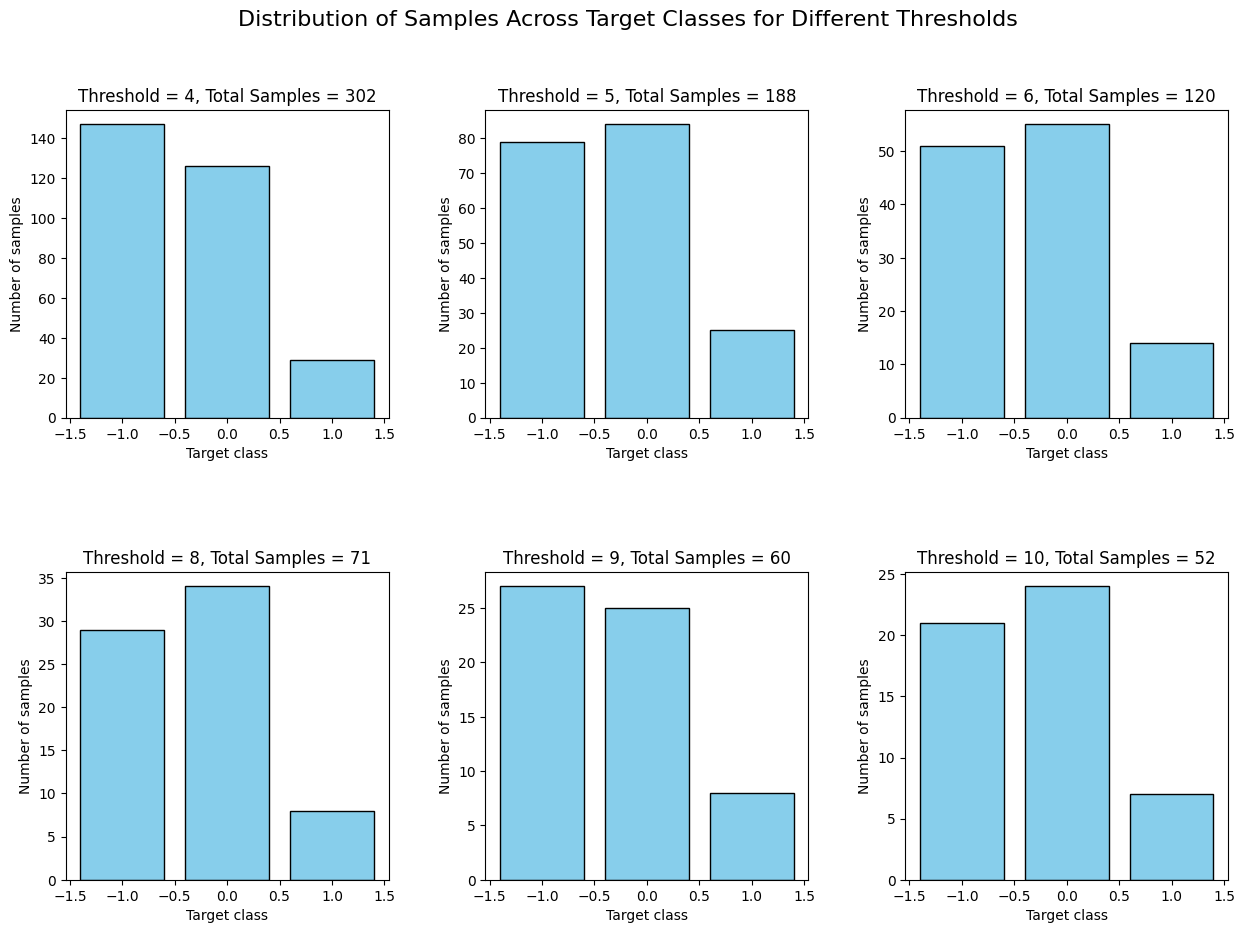

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

threshold = [4,5, 6, 8, 9, 10]
file_list_1 = ["data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
file_list_2 = ["data_0905_semicolon.csv","data_2705_semicolon.csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
target = [-1, 0, 1]
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots

for i, T in enumerate(threshold):
    row_index = i // 3
    col_index = i % 3

    all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold

    for file_name in file_list_1:
        data_set = pd.read_csv(file_name, sep=";")
        input_df = pd.DataFrame(columns=col)

        for ticker in data_set["Ticker"].unique():
            ticker_df = data_set[data_set["Ticker"] == ticker]
            articles_list = ticker_df["Titles"].to_list()

            if len(articles_list) >= T:
                articles_list = articles_list[:T]
                ticker_target = ticker_df["Target"].iloc[0]
                new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
                input_df.loc[len(input_df.index)] = new_row
        all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

    # Plot the distribution of samples for the current threshold
    ax = axes[row_index, col_index]
    ax.bar(target, [all_data_set[all_data_set["Target"] == t].shape[0] for t in target], color='skyblue',
           edgecolor='black')
    ax.set_xlabel('Target class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Threshold = ' + str(T) + ", Total Samples = " + str(all_data_set.shape[0]))

# Add a common title for all subplots
fig.suptitle('Distribution of Samples Across Target Classes for Different Thresholds', fontsize=16)

plt.show()

We choose T = 4, the dataset is strongly unbalanced

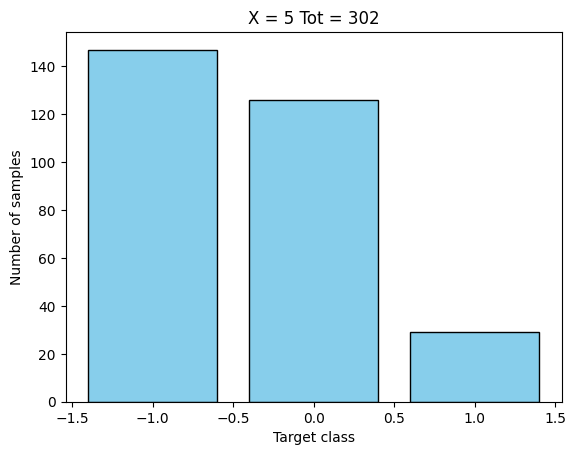

[147, 126, 29]


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
14,APA,APA Shares Pop Since Witnessing a Beat on Q4 E...,APA Co. (NASDAQ:APA) Given Average Recommendat...,How Is The Market Feeling About APA? - APA (NA...,Investors in APA Group (ASX:APA) have seen ret...,,,,,,,1.0,APA Shares Pop Since Witnessing a Beat on Q4 E...
57,HAS,Should You Invest in Nvidia After Its Stock Sp...,Nvidia Soars On Tesla Chief Musk's AI Startup ...,PlayStation Portal stock tracker - TechRadar,"Nvidia Stock Price Prediction: 258% Upside, $1...",,,,,,,1.0,Should You Invest in Nvidia After Its Stock Sp...
132,UNH,UNITEDHEALTH GROUP INC. (NYSE: UNH) DEADLINE A...,"Heritage Wealth Advisors Sells 5,284 Shares of...",Wall Street Favorites: 3 Healthcare Stocks Wit...,(UNH) Long Term Investment Analysis - Stock Tr...,,,,,,,0.0,UNITEDHEALTH GROUP INC. (NYSE: UNH) DEADLINE A...


In [19]:
all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold
T = 4
for file_name in file_list_1:
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set

input_df = input_df.dropna()
'''
# We rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])

'''
plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = '+ str(T)+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
input_df.sample(n=3)

Now we divide the dataset in training set, validation set and test set

In [20]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_Final_test, y_train, y_Final_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_test, y_train, y_test = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

y_train = y_train + 1            
y_test = y_test + 1
y_Final_test = y_Final_test + 1

### Here starts model training

In [11]:
model_name = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
transformer = text.Transformer(model_name, maxlen=512, class_names= np.array([0,1,2]))

In [196]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_test = transformer.preprocess_test(list(x_test["Concatenated Titles"]), list(y_test["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 137
	95percentile : 160
	99percentile : 174


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\utils.py:769: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  "class_names implies classification but targets array contains float(s) instead of integers or strings"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 137
	95percentile : 164
	99percentile : 169


In [197]:
model = transformer.get_classifier()
batch_size = 5                        #small training dataset
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=batch_size)

In [198]:
print(processed_train.y)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [199]:
learner.lr_find(show_plot=True,  max_epochs=1)

simulating training for different learning rates... this may take a few moments...
11/79 [===>..........................] - ETA: 8:00 - loss: 3.9224 - accuracy: 0.3636

In [ ]:
learner.fit_onecycle(0.5e-1, 2)



begin training using onecycle policy with max lr of 0.05...
Epoch 1/2
80/80 [==============================] - 518s 6s/step - loss: 3.8166 - accuracy: 0.5603 - val_loss: 1.9656 - val_accuracy: 0.1800
Epoch 2/2
80/80 [==============================] - 565s 7s/step - loss: 6.6673 - accuracy: 0.5402 - val_loss: 4.6888 - val_accuracy: 0.5900


In [ ]:
learner.validate(class_names=transformer.get_classes())

4/4 [==============================] - 27s 6s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.59      1.00      0.74        59
           2       0.00      0.00      0.00        18

    accuracy                           0.59       100
   macro avg       0.20      0.33      0.25       100
weighted avg       0.35      0.59      0.44       100



c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0, 23,  0],
       [ 0, 59,  0],
       [ 0, 18,  0]], dtype=int64)

In [ ]:
'''
# let's see some predictions
'''
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
import random as rand
i = rand.randint(0,100)

print(input_df["Ticker"].iloc[i],"\n",\
      "Prediction: \n",\
      predictor.predict(x_test["Concatenated Titles"].iloc[i]),\
      "\nTarget: \n",\
      y_train["Target"].iloc[i])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

It always predicts class 1... not really good

### Let's try embedding + NN

In [5]:
from sentence_transformers import SentenceTransformer

In [12]:
#m = SentenceTransformer("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # the most downloaded

In [13]:
#len(m.encode("I love transformers!"))     #768 dimensional embedding
c = len(m.encode("I love transformers!"))                   # dim embedding
r = input_df.shape[0]    # dim dataset  

X = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(input_df.iloc[idx,:].loc["Concatenated Titles"])
  X[idx,:] = sentence_embeddings

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [18]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train[i])  
    y_train_dummy[i, class_idx] = 1


y_test_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
    y_test_dummy[i,round(y_test[i])] = 1

KeyError: 0

In [ ]:
model=Sequential()
model.add(Dense(units=3000, activation='linear', input_dim=c))
model.add(Dense(units=500, activation='tanh'))
model.add(Dense(units=300, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))    #output layer
model.compile(loss='mse',
              optimizer=Adam(lr=0.0001,beta_1=0.9,beta_2=0.999))

model.fit(x_train,y_train,epochs=200,batch_size=10)  #10, 5 


pred_train=model.predict(x_train)
pred_test=model.predict(x_test)

Epoch 1/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2967
Epoch 2/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2939
Epoch 3/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2940
Epoch 4/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2937
Epoch 5/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2938
Epoch 6/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2934
Epoch 7/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2934
Epoch 8/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2940
Epoch 9/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2938
Epoch 10/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2935
Epoch 11/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2934
Epoch 12/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2925
Epoch 13/200
40/40 [=====

In [ ]:
'''
model=Sequential()
model.add(Dense(units=c, activation='relu', input_dim=c))
model.add(Dense(units=900, activation='tanh'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))    #output layer
model.compile(loss='mse',
              optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999))

model.fit(x_train,y_train,epochs=200,batch_size=6)  


pred_train=model.predict(x_train)
pred_test=model.predict(x_test)

Missclasification_train:  0.29396984924623115
Missclassification_test:  0.41

predicts ONLY class 1...
'''

"\nmodel=Sequential()\nmodel.add(Dense(units=c, activation='relu', input_dim=c))\nmodel.add(Dense(units=900, activation='tanh'))\nmodel.add(Dense(units=200, activation='relu'))\nmodel.add(Dense(units=3, activation='sigmoid'))    #output layer\nmodel.compile(loss='mse',\n              optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999))\n\nmodel.fit(x_train,y_train,epochs=200,batch_size=6)  \n\n\npred_train=model.predict(x_train)\npred_test=model.predict(x_test)\n\nMissclasification_train:  0.29396984924623115\nMissclassification_test:  0.41\n\npredicts ONLY class 1...\n"

In [ ]:
'''
model=Sequential()
model.add(Dense(units=c, activation='linear', input_dim=c))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))    #output layer
model.compile(loss='mse',
              optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999))

model.fit(x_train,y_train,epochs=200,batch_size=6) 


pred_train=model.predict(x_train)
pred_test=model.predict(x_test)
Missclasification_train:  0.7412060301507538
Missclassification_test:  0.7
'''

"\nmodel=Sequential()\nmodel.add(Dense(units=c, activation='linear', input_dim=c))\nmodel.add(Dense(units=200, activation='relu'))\nmodel.add(Dense(units=3, activation='sigmoid'))    #output layer\nmodel.compile(loss='mse',\n              optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999))\n\nmodel.fit(x_train,y_train,epochs=200,batch_size=6) \n\n\npred_train=model.predict(x_train)\npred_test=model.predict(x_test)\nMissclasification_train:  0.7412060301507538\nMissclassification_test:  0.7\n"

In [ ]:
pred_test_2 = np.zeros(pred_test.shape)
for i in range(len(pred_test)):
  pred_test_2[i, pred_test[i,:].argmax()  ] = 1

pred_train_2 = np.zeros(pred_train.shape)
for i in range(len(pred_train)):
  pred_train_2[i, pred_train[i,:].argmax()  ] = 1

In [ ]:
#print(pred_train.shape,"--",x_train.shape)
#print(pred_test.shape,"--",x_test.shape)

print(pred_train[23,:],"--",y_train_dummy[0,:])
print(  )
print("Prediction","--","  Target")
for i in range(180,200):
  print(pred_train_2[i,:],"--",y_train_dummy[i,:])

[0.999998   0.99999815 0.99999744] -- [0. 1. 0.]

Prediction --   Target
[0. 0. 1.] -- [0. 1. 0.]
[0. 1. 0.] -- [0. 1. 0.]
[0. 1. 0.] -- [0. 1. 0.]
[0. 0. 1.] -- [1. 0. 0.]
[0. 0. 1.] -- [0. 0. 1.]
[0. 0. 1.] -- [0. 1. 0.]
[1. 0. 0.] -- [1. 0. 0.]
[0. 0. 1.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [0. 1. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[0. 0. 1.] -- [1. 0. 0.]
[1. 0. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [0. 1. 0.]
[0. 0. 1.] -- [0. 1. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[0. 1. 0.] -- [0. 1. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[1. 0. 0.] -- [0. 1. 0.]


It predicts different classes!!!

In [ ]:
MSE_train = np.sum(  (pred_train-y_train_dummy)**2)   /pred_train.shape[0]
MSE_test = np.sum(  (pred_test-y_test_dummy)**2)   /pred_test.shape[0]

print("MSE_train: ",MSE_train)
print("MSE_test: ",MSE_test)


MSE_train = np.sum(  (pred_train_2-y_train_dummy)**2)   /pred_train.shape[0]
MSE_test = np.sum(  (pred_test_2-y_test_dummy)**2)   /pred_test.shape[0]

print("MSE_train: ",MSE_train)
print("MSE_test: ",MSE_test)

MSE_train:  1.8503334895666848
MSE_test:  1.8050412938987537
MSE_train:  1.3668341708542713
MSE_test:  1.36


In [ ]:
miss_train = np.sum(  abs(pred_train_2-y_train_dummy)/2)   /pred_train.shape[0]
miss_test = np.sum(  abs(pred_test_2-y_test_dummy)/2)   /pred_test.shape[0]

print("Missclasification_train: ",miss_train)
print("Missclassification_test: ",miss_test)

Missclasification_train:  0.6834170854271356
Missclassification_test:  0.68


In [ ]:
'''
model=Sequential()
model.add(Dense(units=c, activation='linear', input_dim=c))
model.add(Dense(units=800, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))    #output layer
model.compile(loss='mse',
              optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999))

model.fit(x_train,y_train,epochs=10000,batch_size=6) 


Non-trivial predictions!!!!!!!!!!
'''

"\nmodel=Sequential()\nmodel.add(Dense(units=c, activation='linear', input_dim=c))\nmodel.add(Dense(units=800, activation='relu'))\nmodel.add(Dense(units=3, activation='sigmoid'))    #output layer\nmodel.compile(loss='mse',\n              optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999))\n\nmodel.fit(x_train,y_train,epochs=10000,batch_size=6) \n\n\nNon-trivial predictions!!!!!!!!!!\n"

In [ ]:
'''
model=Sequential()
model.add(Dense(units=900, activation='relu', input_dim=c))
model.add(Dense(units=300, activation='tanh'))
model.add(Dense(units=3, activation='sigmoid'))    #output layer
model.compile(loss='mse',
              optimizer=Adam(lr=0.0001,beta_1=0.9,beta_2=0.999))

model.fit(x_train,y_train,epochs=200,batch_size=10)  #10, 5 


pred_train=model.predict(x_train)
pred_test=model.predict(x_test)

Missclasification_train:  0.5753768844221105
Missclassification_test:  0.53
'''

"\nmodel=Sequential()\nmodel.add(Dense(units=900, activation='relu', input_dim=c))\nmodel.add(Dense(units=300, activation='tanh'))\nmodel.add(Dense(units=3, activation='sigmoid'))    #output layer\nmodel.compile(loss='mse',\n              optimizer=Adam(lr=0.0001,beta_1=0.9,beta_2=0.999))\n\nmodel.fit(x_train,y_train,epochs=200,batch_size=10)  #10, 5 \n\n\npred_train=model.predict(x_train)\npred_test=model.predict(x_test)\n\nMissclasification_train:  0.5753768844221105\nMissclassification_test:  0.53\n"